In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [10]:
class DelayAnalysis:

    def __init__(self, folder, file):
        self.raw_data = self.read_out_tr(folder, file)
        self.tcp_pkt = self.get_tcp_packets(self.raw_data)
        history = self.tcp_pkt.groupby('pkt_id')
        self.duration = (history['time'].last() - history['time'].first()) * 1e6
        
    def read_out_tr(self, dir, file):
        col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
        df = pd.read_csv(dir+file, sep = ' ', header = None)
        df.columns = col
        return df
    
    def get_tcp_packets(self, df):
        df_out = df.loc[df["pkt_type"].isin(["tcp"])]
        return df_out
    
    def get_pkt_detail_by_pktid(self, id):
        return self.tcp_pkt[self.tcp_pkt['pkt_id'] == id]
    
    def dropped_pkt_and_id(self):
        history = self.tcp_pkt.groupby('pkt_id')
        dropped_pkt_id = (history['events'].last() == 'd')
        dropped_pkt_id = dropped_pkt_id[dropped_pkt_id]
        dropped = self.tcp_pkt[self.tcp_pkt.pkt_id.isin(dropped_pkt_id.index)]
        dropped.set_index(['pkt_id', dropped.index], inplace = True)
        return dropped, dropped_pkt_id.index.tolist()
    
    def print_pkt_delay(self, rtt, title=None):
        # us
        duration = self.duration
        drop_id = self.dropped_pkt_and_id()[1]
        #plt.figure(figsize=(20, 8))
        plt.scatter(duration.index, duration, label='received')
        plt.xlabel('pkt_id')
        plt.ylabel('delay(ms)')
        plt.axhline(y=rtt/2, color='g', linestyle='-')
        plt.scatter(duration[drop_id].index, duration[drop_id], color='r', label='drop')
        plt.legend()
        plt.title(title)
        plt.show()
        
    def filter_by_delay(self, boolFunc):
        duration = self.duration
        filter_pkt = self.tcp_pkt[self.tcp_pkt.pkt_id.isin(duration[boolFunc].index)]
        filter_pkt.set_index(['pkt_id', filter_pkt.index], inplace = True)
        return filter_pkt

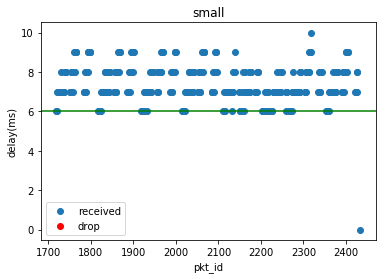

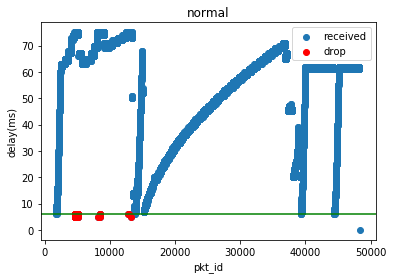

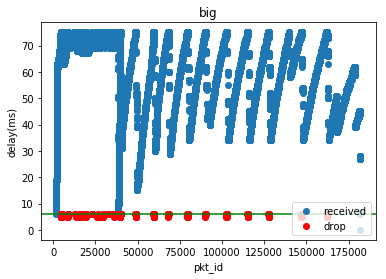

In [13]:
if __name__ == '__main__':
    #pd.set_option('display.width',1000)
    directory = "/home/ovs2/lining/Gearbox/manual/DropTail/"
    SmallDropTailDelay = DelayAnalysis(directory, 'small-out.tr')
    SmallDropTailDelay.print_pkt_delay(12, 'small')
    NormalDropTailDelay = DelayAnalysis(directory, 'normal-out.tr')
    NormalDropTailDelay.print_pkt_delay(12, 'normal')
    BigDropTailDelay = DelayAnalysis(directory, 'big-out.tr')
    BigDropTailDelay.print_pkt_delay(12, 'big')

In [11]:
if __name__=='__main__':
    res = DropTailDelay.filter_by_delay(lambda delay: (40 < delay))
    display(res)

events      time  from_node  to_node pkt_type  pkt_size    flags  fid  src_addr  dst_addr  seq_num
pkt_id                                                                                                          
2194   13000       +  1.005723         23       13      tcp      1500  ------N    7      23.0     35.30   436541
       13001       -  1.005723         23       13      tcp      1500  ------N    7      23.0     35.30   436541
2195   13002       +  1.005723         23       13      tcp      1500  ------N    7      23.0     35.30   438001
       13020       -  1.005723         23       13      tcp      1500  ------N    7      23.0     35.30   438001
2204   13158       +  1.005724         23       13      tcp      1500  ------N    7      23.0     35.30   446761
       13176       -  1.005724         23       13      tcp      1500  ------N    7      23.0     35.30   446761
2194   13192       r  1.005724         23       13      tcp      1500  ------N    7      23.0     35.30   436541
       13193       +  1.005724         13        1      tcp      1500  ------N    7      23.0     35.30   436541
       13194       -  1.005724         13        1      tcp      1500  ------N    7      23.0     35.30   436541
2206   13208       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   448221
       13209       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   448221
2207   13210       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   449681
2195   13213       r  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   438001
       13214       +  1.005725         13        1      tcp      1500  ------N    7      23.0     35.30   438001
       13215       -  1.005725         13        1      tcp      1500  ------N    7      23.0     35.30   438001
2207   13228       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   449681
2209   13260       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   451141
       13261       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   451141
2210   13262       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   452601
       13280       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   452601
2212   13312       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   454061
       13313       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   454061
2213   13314       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   455521
       13332       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   455521
2215   13364       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   456981
       13365       -  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   456981
2216   13366       +  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   458441
2204   13369       r  1.005725         23       13      tcp      1500  ------N    7      23.0     35.30   446761
       13370       +  1.005725         13        1      tcp      1500  ------N    7      23.0     35.30   446761
       13371       -  1.005725         13        1      tcp      1500  ------N    7      23.0     35.30   446761
...              ...       ...        ...      ...      ...       ...      ...  ...       ...       ...      ...
48210  845611      -  1.014497         19       35      tcp      1500  ------N   28      21.3     35.16  2898101
48202  845618      r  1.014497         19       35      tcp      1500  ------N   28      21.3     35.16  2892261
48212  845631      -  1.014497         19       35      tcp

In [12]:
if __name__ == '__main__':
    res = DropTailDelay.get_pkt_detail_by_pktid(2194)
    display(res)

,events,time,from_node,to_node,pkt_type,pkt_size,flags,fid,src_addr,dst_addr,seq_num,pkt_id
13000,+,1.005723,23,13,tcp,1500,------N,7,23.0,35.3,436541,2194
13001,-,1.005723,23,13,tcp,1500,------N,7,23.0,35.3,436541,2194
13192,r,1.005724,23,13,tcp,1500,------N,7,23.0,35.3,436541,2194
13193,+,1.005724,13,1,tcp,1500,------N,7,23.0,35.3,436541,2194
13194,-,1.005724,13,1,tcp,1500,------N,7,23.0,35.3,436541,2194
13385,r,1.005726,13,1,tcp,1500,------N,7,23.0,35.3,436541,2194
13386,+,1.005726,1,10,tcp,1500,------N,7,23.0,35.3,436541,2194
13387,-,1.005726,1,10,tcp,1500,------N,7,23.0,35.3,436541,2194
13580,r,1.005727,1,10,tcp,1500,------N,7,23.0,35.3,436541,2194
13581,+,1.005727,10,7,tcp,1500,------N,7,23.0,35.3,436541,2194


### coding example

[1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997, 2000, 2003] ...


events      time  from_node  to_node pkt_type  pkt_size    flags  fid  src_addr  dst_addr  seq_num
pkt_id                                                                                                        
1976   9212      +  1.005701         23       13      tcp      1500  ------N    7      23.0      35.3   224841
       9225      -  1.005702         23       13      tcp      1500  ------N    7      23.0      35.3   224841
1979   9255      +  1.005702         23       13      tcp      1500  ------N    7      23.0      35.3   227761
       9268      -  1.005702         23       13      tcp      1500  ------N    7      23.0      35.3   227761
1982   9300      +  1.005702         23       13      tcp      1500  ------N    7      23.0      35.3   230681

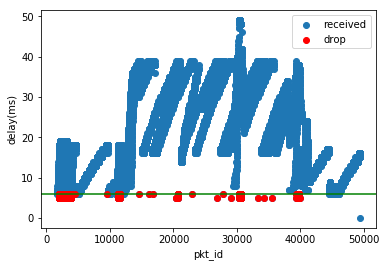

In [15]:
if __name__ == '__main__':
    AFQ10folder = "/home/ovs2/lining/Gearbox/manual/AFQ10/"
    AFQ10delay = DelayAnalysis(AFQ10folder, 'out.tr')
    HRCCfolder = "/home/ovs2/lining/Gearbox/manual/HRCC/"
    HRCCdelay = DelayAnalysis(HRCCfolder, 'out.tr')

    drop_pkt, drop_pkt_id = AFQ10delay.dropped_pkt_and_id()
    print(drop_pkt_id[:10], '...')
    display(drop_pkt.head())

    AFQ10delay.print_pkt_delay(12)

### <span style="color:red"> here is a problem, boundary is also included</span>.

In [14]:
if __name__ == '__main__':
    # below 6 ms
    res = AFQ10delay.filter_by_delay(lambda delay: (10 < delay) & (delay < 12))
    display(res.head())
    display(AFQ10delay.get_pkt_detail_by_pktid(1800))

events      time  from_node  to_node pkt_type  pkt_size    flags  fid  src_addr  dst_addr  seq_num
pkt_id                                                                                                        
1800   6369      +  1.005674         23       13      tcp      1500  ------N    7      23.0      35.3    70081
       6376      -  1.005674         23       13      tcp      1500  ------N    7      23.0      35.3    70081
1801   6390      +  1.005674         23       13      tcp      1500  ------N    7      23.0      35.3    71541
       6391      -  1.005674         23       13      tcp      1500  ------N    7      23.0      35.3    71541
1802   6392      +  1.005674         23       13      tcp      1500  ------N    7      23.0      35.3    73001

,events,time,from_node,to_node,pkt_type,pkt_size,flags,fid,src_addr,dst_addr,seq_num,pkt_id
6369,+,1.005674,23,13,tcp,1500,------N,7,23.0,35.3,70081,1800
6376,-,1.005674,23,13,tcp,1500,------N,7,23.0,35.3,70081,1800
6459,r,1.005675,23,13,tcp,1500,------N,7,23.0,35.3,70081,1800
6460,+,1.005675,13,1,tcp,1500,------N,7,23.0,35.3,70081,1800
6461,-,1.005675,13,1,tcp,1500,------N,7,23.0,35.3,70081,1800
6550,r,1.005676,13,1,tcp,1500,------N,7,23.0,35.3,70081,1800
6551,+,1.005676,1,10,tcp,1500,------N,7,23.0,35.3,70081,1800
6552,-,1.005676,1,10,tcp,1500,------N,7,23.0,35.3,70081,1800
6645,r,1.005678,1,10,tcp,1500,------N,7,23.0,35.3,70081,1800
6646,+,1.005678,10,7,tcp,1500,------N,7,23.0,35.3,70081,1800
